# DIAL Studies

This code loads the simulated online and offline channels and performs Standard and CDC corrections. The corrected data is then used to further process as a DIAL retrieval.

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import time
import xarray as xr
import pickle
from pathlib import Path

# import library for simulating Poisson point processes
cwd = os.getcwd()
dirLib = cwd + r'/library'
if dirLib not in sys.path:
    sys.path.append(dirLib)

import sim_deadtime_utils as sim
from load_ARSENL_data import set_binwidth

import fit_polynomial_utils_cloud as fit
import data_organize as dorg

eps = sys.float_info.epsilon

In [58]:
# Constants

c = 299792458  # [m/s] speed of light
k_B = 1.380649e-23  # [m^2 kg s-2 K-1]
g_0 = 9.81  # [m s-2] Gravity
M_air = 28.97  # [g/mol] Molar mass of air
R_0 = 8.314459  # [J/mol/K] Universal gas constant
N_A = 6.022e23  # [atoms / mol] Avogadro's number
h = 6.626e-34  # [J s] Planck's constant

L = 9e-3  # [K/km] Temperature lapse rate for Denver
P_0 = 840  # [mbar] Typical absolute pressure for Denver
T_0 = 294.3  # [K] Typical 70 F temperature for Denver
lamb = 828e-9  # [m] laser wavelength

D = 8  # [in] outer diameter of telescope
d = 1.8  # [in] inner diameter of telescope

dt_TCSPC = 250e-12  # [s] native resolution of TCSPC

# Laser specs
P_L = 35e-3 * 8  # [W] average laser power
dt_L = 700e-12  # [s] laser pulse FWHM
f_L = 14.7e3  # [Hz] rep rate

# Receiver specs (at 532 nm)
R_tele = 0.95  # Telescope reflectance
R_M = 0.99  # Folding mirror reflectance
T_L = 0.9  # Standard lens transmittance
mu_F = 0.994  # [m-1] Fiber transmission coefficient
L_F = 2  # [m] Fiber length
T_F = mu_F * L_F  # Fiber transmittance
T_FC = T_L  # Fiber coupler transmittance
T_BS_LG = 0.05  # Beam-splitter low-gain transmittance
T_BS_HG = 0.95  # Beam-splitter high-gain transmittance
T_SBF = 0.9  # Solar background filter transmittance
eta_QE = 0.5  # Detector quantum efficiency
loss = 10  # Unaccounted loss term
tD = 20e-9  # [s] SPAD deadtime

dalt = c * dt_TCSPC / 2  # [m]
alt = np.arange(eps, 1.25e3, dalt)  # [m] target range
xsec = 1e-26  # [m^2]

### Load sim, correct, then perform DIAL calculation

In [59]:
# Load data

# Constants
c = 299792458  # [m/s] speed of light

# Parameters
home = str(Path.home())
load_dir = os.path.join(home, 'OneDrive - UCB-O365', 'ARSENL', 'Experiments', 'Cloud Measurements', 'Sims', 'saved_sims')
# load_dir = home + r'\OneDrive - UCB-O365\ARSENL\Experiments\Digitization Tests\Sims\saved_sims'

fname_off = r'simnum_1_amp_7.92E+07off_nshot1.00E+04_OFF.nc'
fname_on = r'simnum_1_amp_7.92E+07off_nshot1.00E+04_ON.nc'

ds_off = xr.open_dataset(os.path.join(load_dir, fname_off))
ds_on = xr.open_dataset(os.path.join(load_dir, fname_on))

phot_events_off = ds_off.true_time_tag.values
dt_sim = ds_off.dt_sim.values  # [s]
sim_time = ds_off.t_sim_bins.values  # [s]
Nshot = ds_off.sync_index.values[-1] + 1
det_events_off = ds_off.time_tag.values
det_sync_idx_off = ds_off.time_tag_sync_index
phot_sync_idx_off = ds_off.true_time_tag_sync_index
photon_rate_off_shift = ds_off.photon_rate_arr.values
tD = ds_off.dtime.values  # [s] deadtime
window_bnd = ds_off.window_bnd.values  # [m]

phot_events_on = ds_on.true_time_tag.values
det_events_on = ds_on.time_tag.values
det_sync_idx_on = ds_on.time_tag_sync_index
phot_sync_idx_on = ds_on.true_time_tag_sync_index
photon_rate_on_shift = ds_on.photon_rate_arr.values


In [60]:
det_events_ordered_off = []
phot_events_ordered_off = []
for i in range(Nshot):
    det_idx_off = np.where(np.array(det_sync_idx_off)==i)[0]
    phot_idx_off = np.where(np.array(phot_sync_idx_off)==i)[0]
    if det_idx_off.size == 0:
        det_events_ordered_off.append([])
    else:
        det_events_shot_off = det_events_off[det_idx_off]
        det_events_ordered_off.append(det_events_shot_off)
    if phot_idx_off.size == 0:
        phot_events_ordered_off.append([])
    else:
        phot_events_shot_off = phot_events_off[phot_idx_off]
        phot_events_ordered_off.append(phot_events_shot_off)

In [61]:
avg_range = 25

shift_bot = window_bnd[0]  # [m]
shift_top = window_bnd[1]  # [m]

plot_bins = sim_time[::avg_range] + shift_bot/c*2  # [s]

n_det_off, bins = np.histogram(det_events_off*dt_sim, bins=plot_bins)
dt = np.diff(bins)[0]
det_flux_off = n_det_off/dt/Nshot

n_phot_off, _ = np.histogram(phot_events_off*dt_sim, bins=plot_bins)
phot_flux_off = n_phot_off/dt/Nshot

n_det_on, _ = np.histogram(det_events_on*dt_sim, bins=plot_bins)
det_flux_on = n_det_on/dt/Nshot

n_phot_on, _ = np.histogram(phot_events_on*dt_sim, bins=plot_bins)
phot_flux_on = n_phot_on/dt/Nshot

print('Plotting range resolution: {:.2f} m'.format(dt*c/2))

Plotting range resolution: 0.94 m


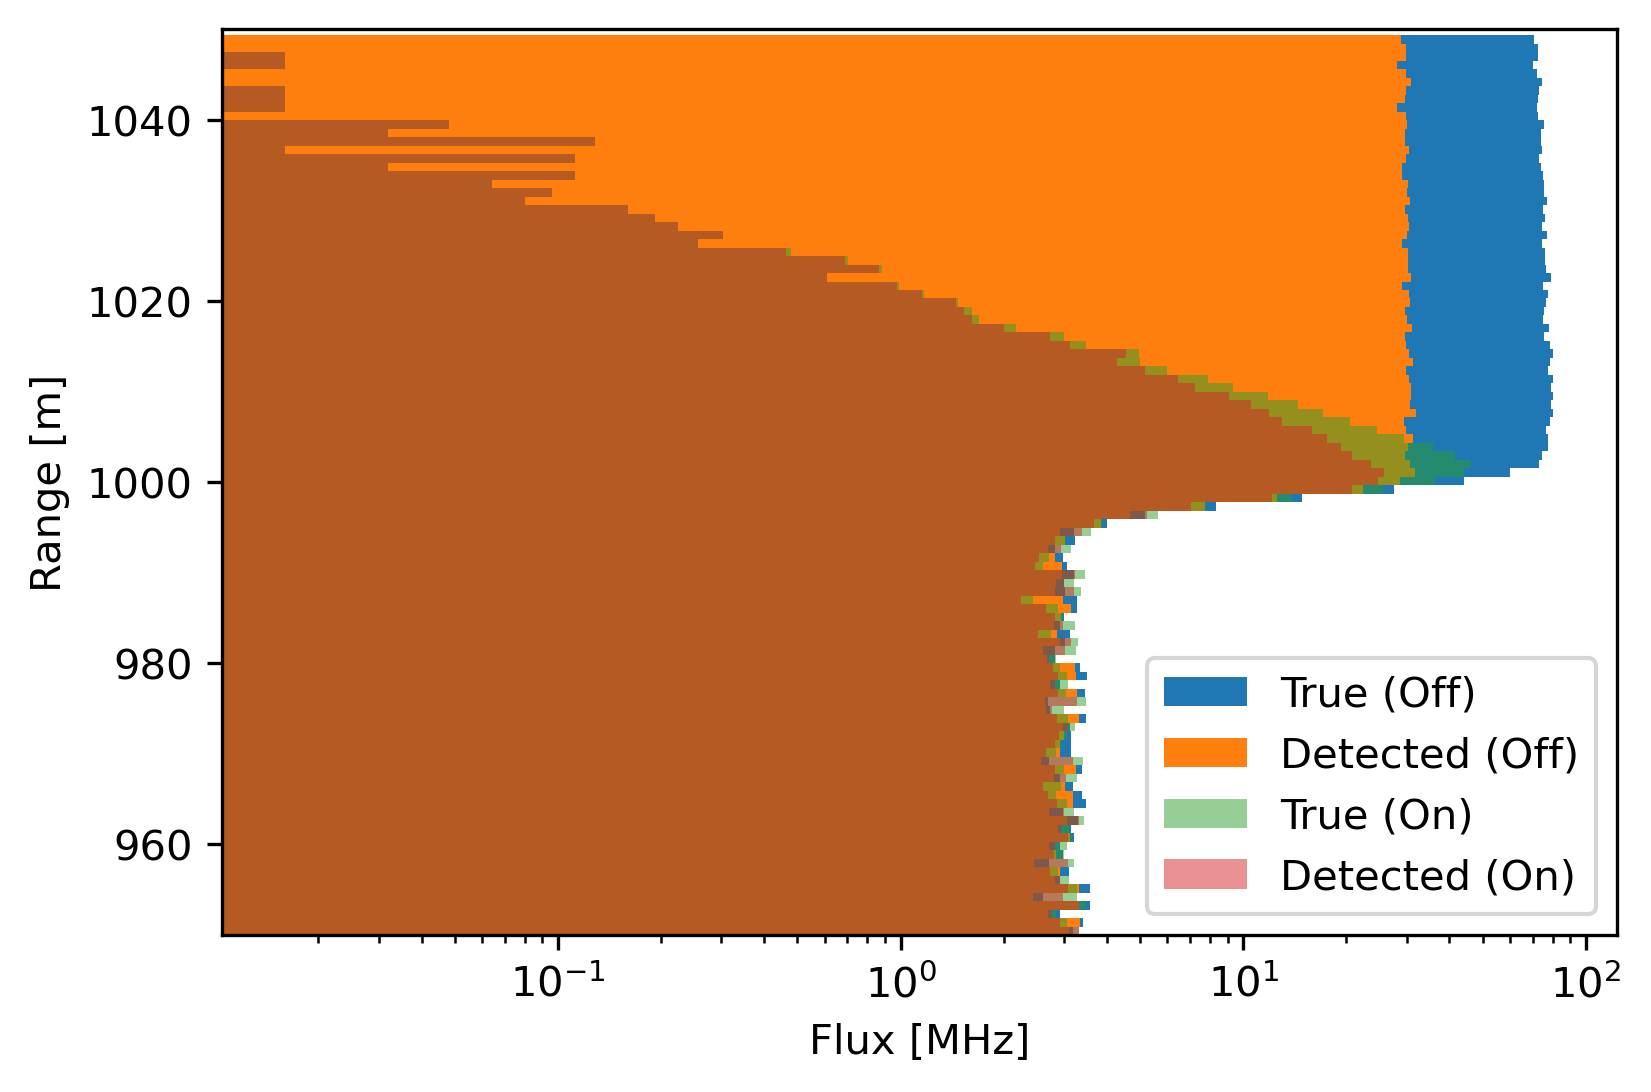

In [62]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111)
ax.barh((plot_bins[:-1]+dt/2)*c/2, phot_flux_off/1e6, height=dt*c/2, label='True (Off)')
ax.barh((plot_bins[:-1]+dt/2)*c/2, det_flux_off/1e6, height=dt*c/2, label='Detected (Off)')
ax.barh((plot_bins[:-1]+dt/2)*c/2, phot_flux_on/1e6, height=dt*c/2, alpha=0.5, label='True (On)')
ax.barh((plot_bins[:-1]+dt/2)*c/2, det_flux_on/1e6, height=dt*c/2, alpha=0.5, label='Detected (On)')
ax.set_ylabel('Range [m]')
ax.set_xlabel('Flux [MHz]')
ax.set_ylim([shift_bot, shift_top])
ax.set_xscale('log')
plt.legend()
plt.show()

In [63]:
dR_avg = dt * c / 2  # [m]
meas_conc = 1/2/xsec/dR_avg*np.diff(np.log(det_flux_off/det_flux_on))  # [m-3]
muller_conc = 1/2/xsec/dR_avg*np.diff(np.log((det_flux_off/(1-tD*det_flux_off))/(det_flux_on/(1-tD*det_flux_on))))  # [m-3]
true_conc = 1/2/xsec/dR_avg*np.diff(np.log((photon_rate_off_shift[::avg_range])/(photon_rate_on_shift[::avg_range])))

C:\Users\Grant\AppData\Local\Temp\ipykernel_11776\1507889306.py:2: RuntimeWarning: divide by zero encountered in divide
  meas_conc = 1/2/xsec/dR_avg*np.diff(np.log(det_flux_off/det_flux_on))  # [m-3]
C:\Users\Grant\anaconda3\envs\arsenl-conda\lib\site-packages\numpy\lib\function_base.py:1448: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
C:\Users\Grant\AppData\Local\Temp\ipykernel_11776\1507889306.py:3: RuntimeWarning: divide by zero encountered in divide
  muller_conc = 1/2/xsec/dR_avg*np.diff(np.log((det_flux_off/(1-tD*det_flux_off))/(det_flux_on/(1-tD*det_flux_on))))  # [m-3]


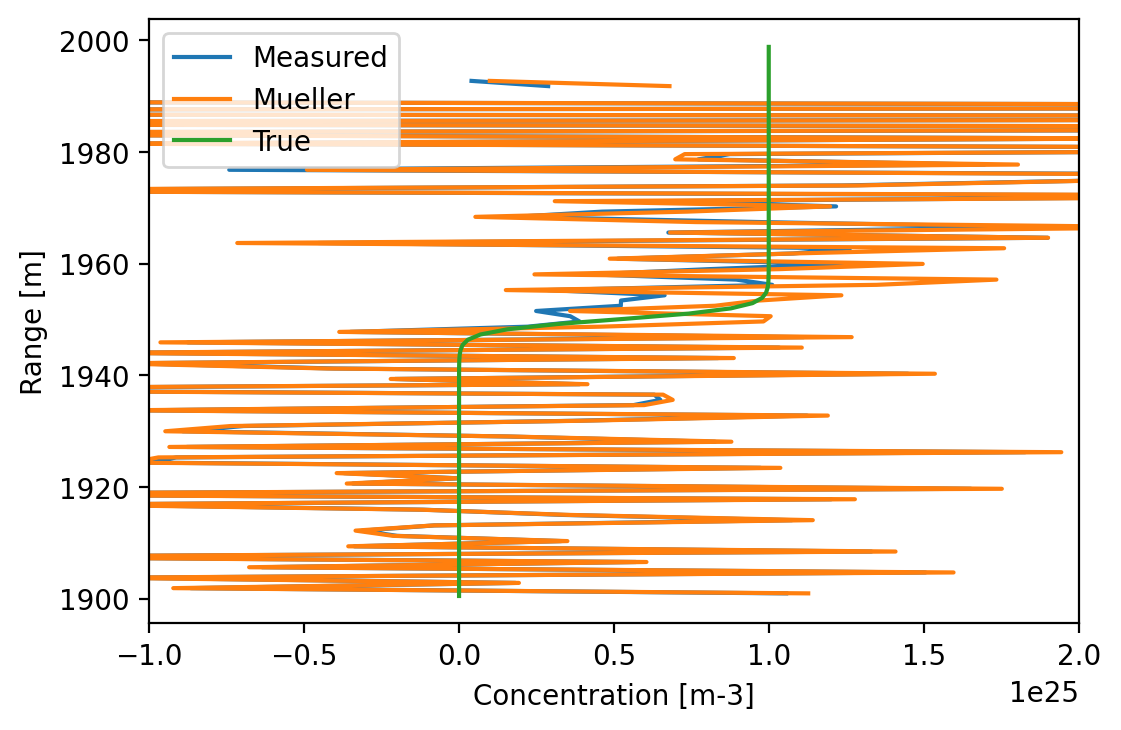

In [64]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
ax.plot(meas_conc, (plot_bins[1:-1])*c/2+shift_bot, label='Measured')
ax.plot(muller_conc, (plot_bins[1:-1])*c/2+shift_bot, label='Mueller')
ax.plot(true_conc, (plot_bins[:-1]+dt/2)*c/2+shift_bot, label='True')
ax.set_xlabel('Concentration [m-3]')
ax.set_ylabel('Range [m]')
ax.set_xlim([-1e25, 2e25])
# ax.set_ylim([980, 1020])
# ax.set_xscale('log')
plt.legend()
plt.show()

In [65]:
t_min = plot_bins[0]  # [s]
t_max = plot_bins[-1]  # [s]
window_bnd = [t_min, t_max]  # [s]

# calculate active fraction histogram
dsamp = 10
intgrl_N = int(len(sim_time)/dsamp)  # number of bins in integral. I usually set this to the number of bins in the histogram for consistency
deadtime = tD  # [s] 

shot_avg = int(10000)
exclude_shots = True

# Check that shot average is divisible by the number of shots
if Nshot % shot_avg != 0:
    print('Change "shot_avg" variable to divisible number!')
    
if type(shot_avg) != int:
    shot_avg = int(shot_avg)
    
num_temporal_bins = Nshot / shot_avg
print('Number of temporal bins: {}'.format(num_temporal_bins))
print('Number of range bins: {}'.format(intgrl_N))

Number of temporal bins: 1.0
Number of range bins: 266


In [66]:
avg_bins = 50
max_idx = (intgrl_N//avg_bins) * avg_bins
rmndr = intgrl_N - max_idx
print('Remainder range bins per column getting thrown away to average to coarser bins: {}'.format(rmndr))

cnts_curtain = np.zeros((int(num_temporal_bins), (intgrl_N//avg_bins)))
muller_curtain = np.zeros((int(num_temporal_bins), (intgrl_N//avg_bins)))
cdc_curtain = np.zeros((int(num_temporal_bins), (intgrl_N//avg_bins)))
active_ratio_curtain = np.zeros((int(num_temporal_bins), intgrl_N))
for i in range(int(num_temporal_bins)):
    flight_time, n_shots, t_det_lst = dorg.data_organize(dt_sim, load_dir, fname_off, window_bnd, shot_avg-1, exclude_shots, repeat_num=i+1)
    t_phot_fit_tnsr = flight_time.values
    n_shots += 1

    active_ratio_hst, AF_bin_edges = fit.deadtime_noise_hist(t_min, t_max, intgrl_N, deadtime, t_det_lst, n_shots)
    active_ratio_hst = active_ratio_hst.detach().numpy()
    active_ratio_hst[np.where(active_ratio_hst==0)[0]] = sys.float_info.min  # if AF=0 for any bin, replace it with small positive value
    active_ratio_curtain[i, :] = active_ratio_hst
    
    Y = np.histogram(t_phot_fit_tnsr, bins=AF_bin_edges)[0]
    cdc = Y / active_ratio_hst

    binwidth = np.diff(AF_bin_edges)[0]
    binwidth_smooth = binwidth * avg_bins

    # Raw counts
    Y_reshape = np.reshape(Y[:max_idx], (len(Y)//avg_bins, avg_bins))
    Y_smooth = np.sum(Y_reshape, axis=1)
    # CDC
    cdc_reshape = np.reshape(cdc[:max_idx], (len(cdc)//avg_bins, avg_bins))
    cdc_smooth_cnts = np.sum(cdc_reshape, axis=1)
    
    cnts_curtain[i, :] = Y_smooth / n_shots / binwidth_smooth  # [Hz]
    muller_curtain[i, :] = cnts_curtain[i, :] / (1-cnts_curtain[i, :]*deadtime)  # [Hz]
    cdc_curtain[i, :] = cdc_smooth_cnts / n_shots / binwidth_smooth  # [Hz]
    
    print('Time bin #{}'.format(i))
    
cnts_curtain = cnts_curtain.T[::-1]
muller_curtain = muller_curtain.T[::-1]
cdc_curtain = cdc_curtain.T[::-1]

Remainder range bins per column getting thrown away to average to coarser bins: 16
Time bin #0


In [67]:
# set up the truth curtain
dim_range = len(sim_time[::avg_bins][:-1])
curtain_truth = np.zeros((intgrl_N//avg_bins, Nshot))
for i in range(Nshot):    
    n, _ = np.histogram((np.array(phot_events_ordered_off[i])*dt_sim), bins=AF_bin_edges[::avg_bins])
    curtain_truth[:, i] = n[::-1]
    
rows, cols = curtain_truth.shape
curtain_truth = curtain_truth.reshape(rows, cols//shot_avg, shot_avg).sum(axis=2)

curtain_truth_flux = curtain_truth / n_shots / binwidth_smooth 

Range binwidth: 18.67 m


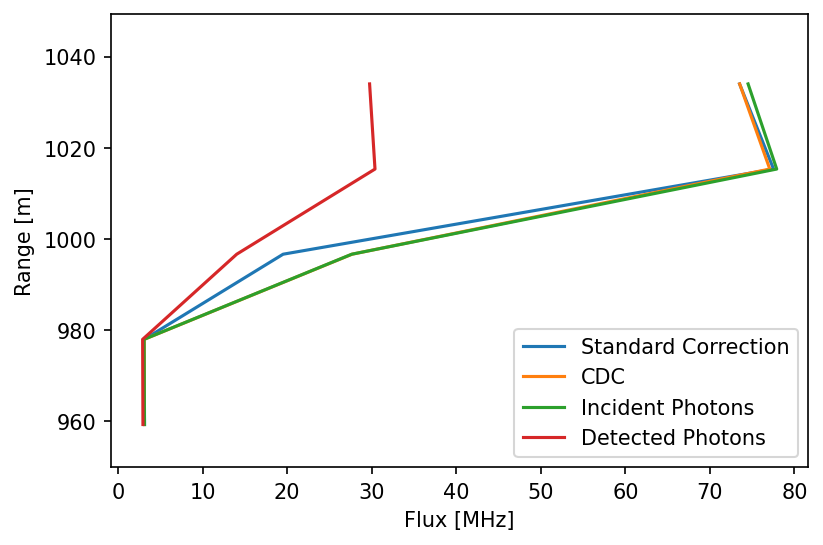

In [70]:
t_plot = np.arange(window_bnd[0]+binwidth_smooth/2, window_bnd[1]-binwidth_smooth/2, binwidth_smooth)
range_plot = t_plot * c / 2  # [m]
print('Range binwidth: {:.2f} m'.format(binwidth_smooth*c/2))

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.plot(muller_curtain[:, 0][::-1]/1e6, range_plot, label='Standard Correction', alpha=1)
ax.plot(cdc_curtain[:, 0][::-1]/1e6, range_plot, label='CDC', alpha=1)
ax.plot(curtain_truth_flux[:, 0][::-1]/1e6, range_plot, label='Incident Photons')
ax.plot(cnts_curtain[:, 0][::-1]/1e6, range_plot, label='Detected Photons')
ax.set_ylabel('Range [m]')
ax.set_xlabel('Flux [MHz]')
ax.set_ylim([window_bnd[0]*c/2, window_bnd[1]*c/2])
# ax.set_title('First Shot')
# ax.set_xscale('log')
# ax.set_xlim([5, 200])
plt.legend()
plt.show()